In [1]:
!pip install sentence_transformers~=2.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.6 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=780e6caf4ab4c3f462cd50f110f95d38bda22d73468ed5ceb4dc9e46e1d335f1
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import re
import pandas as pd
import numpy as np
import sklearn
from scipy.stats import spearmanr, pearsonr
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import pickle as pk

In [10]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('intfloat/multilingual-e5-large')

In [11]:
def loading_file(path):
      # Load the File
      return pd.read_csv(path)


In [12]:
def adding_Original_Lables(data):
      threshold_fn = lambda ele: 1 if ele > 0.5 else 0
      data['Original labels'] = data['Scores'].apply(threshold_fn)


In [13]:
def prepare_input(data):
    input_texts = []
    for x , y in zip(data['Text1'] ,data['Text2']) :
         input_texts.append([f'query: {x}',f'query: {y}'])
    return input_texts




In [14]:
def preparing_embeddings(input,flag):
        for idx,sentence_pair in enumerate(input):
            new_embedding = (model.encode(sentence_pair, normalize_embeddings=True))
            embeddings[idx]=new_embedding
        if flag == 1:
            i = 0
            for embedding in embeddings:
              embedding_set[i] = embedding[0]
              i += 1
              embedding_set[i] = embedding[1]
              i += 1



In [15]:
def dim_reduction_using_pca(all_embedding,embeddings,flag):
      if flag == 1:
              length = all_embedding.shape[0]
              reduced_to_10 = np.zeros((length//2,2,10))
              # Create a PCA object and specify the number of components you want to keep
              n_components = 10  # Change this to the desired number of components
              pca = PCA(n_components=n_components)

              pca.fit(all_embedding)
              # pca = PCA(n_components=n_components)

              # transform the data
              X_pca = pca.transform(all_embedding)  # Use X_scaled if you standardized your data
              pk.dump(pca, open("/content/drive/MyDrive/Task A/pca.pkl","wb"))
              k = 0
              for i in range(0,length-1,2):
                reduced_to_10[k] = np.array([X_pca[i],X_pca[i+1]])
                k += 1
              return reduced_to_10
      else:
        length = embeddings.shape[0]
        reduced_to_10 = np.zeros((length,2,10))
        pca_reload = pk.load(open("/content/drive/MyDrive/Task A/pca.pkl",'rb'))
        for idx,x in  enumerate(embeddings):
            n = pca_reload.transform(x)  # Use X_scaled if you standardized your data
            reduced_to_10[idx] = n
        return reduced_to_10



In [16]:
def culuster_using_DBSCAN(data,reduced_embedding):
      for embedding in reduced_embedding:
          clustering = DBSCAN(eps=0.15, min_samples=2).fit(embedding)
          data['Predicted labels'] = 1 if clustering.labels_[0]==0 and clustering.labels_[1]==0 else 0


In [44]:
df_str_rel = loading_file('/content/drive/MyDrive/train.csv')
# df_str_rel = df_str_rel[:1000]
sentence_pair_count = df_str_rel.shape[0]
df_str_rel.head()

,index,Text1,Text2,Type,Lang,Scores,e5_mean
0,6670,መግለጫውን የተከታተለው የአዲስ አበባው ዘጋቢያችን ሰሎሞን ሙጬ ዝርዝር ዘ...,በስፍራው ተገኝቶ የተከታተለው የአዲስ አበባው ዘጋቢያችን ሰሎሞን ሙጬ ያጠ...,train,amh,0.88,0.960339
1,6671,የኛ ዴሞክራሲ የእንግሊዝ ስርዓት ነው ፤ ለጊዜው ሊያገለግል ይችላል ።,( ሀ) “በሕጉ ዙሪያ ያለው አጥር ” ከንቱ ሆኖ የቀረው ለምንድን ነው ?,train,amh,0.25,0.804716
2,6673,ግን ምን አይነት ቁልፍ ?,ምን አይነት ፍቅር ነዉ ?,train,amh,0.27,0.917702
3,6675,"ሐሙስ ፡-ከምሽቱ ሦስት ሰዓት የአማርኛ ዜና - ሰኔ 25, 2020 ።","ሰኞ ፡-ከምሽቱ ሦስት ሰዓት የአማርኛ ዜና - ኤፕሪል 19, 2021 ።",train,amh,0.59,0.965087
4,6676,ኦሮሞነት ከምንም (ከኢትዮጵያ ጭምር) በላይ ነዉ ፡፡,ከምንም በላይ ነው ይሄ ።,train,amh,0.27,0.867608


In [45]:
adding_Original_Lables(df_str_rel)

In [46]:
input_texts = prepare_input(df_str_rel)

In [47]:
embeddings = np.zeros((sentence_pair_count,2, 1024))

In [48]:
embedding_set = np.zeros((2*sentence_pair_count,1024))

In [49]:
preparing_embeddings(input_texts,1)

In [50]:
reduced_to_10= dim_reduction_using_pca(embedding_set,embeddings,1)

In [51]:
culuster_using_DBSCAN(df_str_rel,reduced_to_10)

In [52]:
df_str_rel.head()

,index,Text1,Text2,Type,Lang,Scores,e5_mean,Original labels,Predicted labels
0,6670,መግለጫውን የተከታተለው የአዲስ አበባው ዘጋቢያችን ሰሎሞን ሙጬ ዝርዝር ዘ...,በስፍራው ተገኝቶ የተከታተለው የአዲስ አበባው ዘጋቢያችን ሰሎሞን ሙጬ ያጠ...,train,amh,0.88,0.960339,1,1
1,6671,የኛ ዴሞክራሲ የእንግሊዝ ስርዓት ነው ፤ ለጊዜው ሊያገለግል ይችላል ።,( ሀ) “በሕጉ ዙሪያ ያለው አጥር ” ከንቱ ሆኖ የቀረው ለምንድን ነው ?,train,amh,0.25,0.804716,0,1
2,6673,ግን ምን አይነት ቁልፍ ?,ምን አይነት ፍቅር ነዉ ?,train,amh,0.27,0.917702,0,1
3,6675,"ሐሙስ ፡-ከምሽቱ ሦስት ሰዓት የአማርኛ ዜና - ሰኔ 25, 2020 ።","ሰኞ ፡-ከምሽቱ ሦስት ሰዓት የአማርኛ ዜና - ኤፕሪል 19, 2021 ።",train,amh,0.59,0.965087,1,1
4,6676,ኦሮሞነት ከምንም (ከኢትዮጵያ ጭምር) በላይ ነዉ ፡፡,ከምንም በላይ ነው ይሄ ።,train,amh,0.27,0.867608,0,1


In [53]:
np.linalg.norm(reduced_to_10[1][0]-reduced_to_10[1][1])

0.1714480459666279

In [54]:
sklearn.metrics.accuracy_score(df_str_rel["Original labels"], df_str_rel["Predicted labels"])

0.45343935619850545

In [56]:
# Load the File
df_str_rel = loading_file('/content/drive/MyDrive/val.csv')
# df_str_rel = df_str_rel[:100]

In [57]:
adding_Original_Lables(df_str_rel)

In [58]:
input_texts = prepare_input(df_str_rel)

In [59]:
sentence_pair_count = df_str_rel.shape[0]

In [60]:
embeddings = np.zeros((sentence_pair_count,2, 1024))

In [61]:
preparing_embeddings(input_texts,0)

In [62]:
reduced_to_10= dim_reduction_using_pca(embedding_set,embeddings,0)

In [63]:
culuster_using_DBSCAN(df_str_rel,reduced_to_10)

In [64]:
df_str_rel.head()

,index,Text1,Text2,Type,Lang,Scores,e5_mean,e5_trained,Labels,Labels_without_training,Labels_with_training,Original labels,Predicted labels
0,6913,ይህ ደግሞ ቀላል አይሆንም ።,ያ ደግሞ ቀላል አይደለም ።,train,amh,0.75,0.995844,0.980574,1,1,1,1,0
1,6806,መንገድ መሪ ከሆነ ማንኛውም ሰው የሚፈለገው ዋነኛ ባሕርይ እምነት የሚጣል...,የበረራ አዲስ መረጃ ፡ ኢትዮጵያን አየርመንገድ አሁንድ ኢስታንቡል እየበረ...,train,amh,0.19,0.805951,0.320204,0,1,0,0,0
2,7283,ነገ ሰኔ 16 ነው ፡፡,ሰኔ 16/17 ትምህርት ቤት ቢባል ይሻላል :-) !,train,amh,0.36,0.898698,0.751506,0,1,1,0,0
3,7578,አንድ ረጅም ልቦለድ እየፃፍኩ ነው ፡፡,ይህ መጽሐፍ ልቦለድ ነው ፡፡,train,amh,0.55,0.913872,0.780404,1,1,1,1,0
4,6939,ሌላም ችግር አለ ነው ያልኩት ::,መቼ የት ነው እንዲህ ያልኩት ?,train,amh,0.30,0.908220,0.451932,0,1,0,0,0


In [76]:
print("combined accuracy for all languages :",sklearn.metrics.accuracy_score(df_str_rel['Original labels'], df_str_rel['Predicted labels']))

combined accuracy for all languages : 0.5612068965517242


In [94]:
names = {   "amh":"Amharic",
            "ary":"Morrocan Arabic",
            "eng":"English",
            "hau":"Hausa",
           "mar":"Marathi",
           "tel":"Telugu"
         }

In [95]:
accuracy_for_each_lang = []
for lang,lang_df in df_str_rel.groupby(by = 'Lang'):
  language = names[lang]
  true_scores = lang_df['Original labels']
  pred_scores = lang_df['Predicted labels']
  accuracy_for_each_lang.append(f'{language} : {sklearn.metrics.accuracy_score(true_scores, pred_scores)}')
  # print(len(df_str_rel['pred score']))

In [99]:
print("Accuracy for each language:")
for x in accuracy_for_each_lang:
  print(x)




Accuracy for each language:
Amharic : 0.5151515151515151
Morrocan Arabic : 0.48
English : 0.5836363636363636
Hausa : 0.5574712643678161
Marathi : 0.5416666666666666
Telugu : 0.5897435897435898


In [ ]:
from sklearn.manifold import TSNE

In [ ]:
df_str_rel

In [ ]:
df_str_rel = df_str_rel.drop(columns=["index"]).reset_index(drop=True)

In [ ]:
def generate_embedding(text_arr):
  num_of_ele = text_arr.shape[0]
  embeddings = np.random.randn(num_of_ele,1024)
  input_texts = []
  for x in text_arr :
        input_texts.append([f'query: {x}'])

  for idx,sentence in enumerate(input_texts):
            new_embedding = (model.encode(sentence, normalize_embeddings=True))
            embeddings[idx]=new_embedding
  return embeddings

In [ ]:
def get_array_elements_of_pos(arr, indices):
    req_reduced_embeddings = np.zeros((len(indices), 2))

    for index_indx, indx in enumerate(indices):
      req_reduced_embeddings[index_indx] = arr[indx]

    return req_reduced_embeddings


In [ ]:
def reduced_and_plot_with_tsne(arr1, arr2, selected_indices):

  combined = np.concatenate((arr1, arr2))
  reduced = TSNE(n_components = 2, ).fit_transform(combined)

  arr1_reduced = reduced[:arr1.shape[0]]
  arr2_reduced = reduced[arr1.shape[0]:arr1.shape[0] + arr2.shape[0]]

  arr1_selected = get_array_elements_of_pos(arr1_reduced, selected_indices)
  arr2_selected = get_array_elements_of_pos(arr2_reduced, selected_indices)

  arr1_df = pd.DataFrame(arr1_selected, columns=["x", "y"])
  arr2_df = pd.DataFrame(arr2_selected, columns=["x", "y"])
  combined = pd.concat((arr1_df, arr2_df))
  combined["color"] = ["red", "orange", "blue", "green", "red", "orange", "blue", "green"]
  combined.plot(kind="scatter", x="x", y="y", color=combined.color)
  return combined

In [ ]:
required_samples_from_each = 2

In [ ]:
df1 = df_str_rel[(df_str_rel.Labels == 1) & (df_str_rel.Labels_with_training == 1)].sort_values(by="Scores", ascending=False).iloc[:required_samples_from_each, :][["Text1", "Text2", "Scores"]]
df2 = df_str_rel[(df_str_rel.Labels == 0) & (df_str_rel.Labels_with_training == 0)].sort_values(by="Scores", ascending=True).iloc[:required_samples_from_each, :][["Text1", "Text2", "Scores"]]
evaluate_df =pd.concat((df1, df2))
evaluate_df.index


Int64Index([159, 784, 892, 903], dtype='int64')

In [ ]:
text_1_emb_matrix = generate_embedding(df_str_rel.Text1.values)
text_2_emb_matrix = generate_embedding(df_str_rel.Text2.values)

In [ ]:
text_1_emb_matrix

array([[ 0.02010147,  0.00748427, -0.00252514, ...,  0.00882552,
        -0.03338804,  0.00288767],
       [ 0.0131381 , -0.02705168, -0.01036351, ...,  0.00539531,
        -0.0391196 ,  0.02416015],
       [ 0.03327774,  0.00277705, -0.0086819 , ..., -0.0084637 ,
        -0.01854756,  0.02103318],
       ...,
       [ 0.03447696, -0.01231311, -0.0152896 , ...,  0.01054086,
         0.00433405, -0.00441876],
       [ 0.01152627, -0.02890432, -0.0257138 , ...,  0.00518504,
        -0.03701706,  0.00489122],
       [ 0.0377011 , -0.02137386, -0.0327568 , ..., -0.002317  ,
        -0.0392115 , -0.00707778]])

In [ ]:
evaluate_df

,Text1,Text2,Scores
159,ها شكون اطلع ليهوم الجوك هاد السيمانة ف تعيينا...,هادو اطلع ليهوم الجوك هاد الأسبوع في تعيينات ا...,1.0
784,TAƘADDAMAR ‘FARFESA’ PANTAMI: Tsoffin Ɗaliban ...,“Mu tsoffin ɗaliban FUTO mun ƙara nanata matsa...,1.0
892,“Onyekwe dan asalin karamar hukumar Owerri ta ...,Kasurgumin Dan Bindiga mai suna Damina wanda y...,0.0
903,Jega ya ce wannan labari ya samo asaline daga ...,Ya ce Almajirai da mabarata na kwararowa ne sa...,0.0


,x,y,color
0,-10.174488,52.580791,red
1,9.464701,24.065990,orange
2,18.502659,35.020695,blue
3,33.695118,20.689201,green
0,-10.245955,52.698219,red
1,9.568923,23.881762,orange
2,26.935234,29.184950,blue
3,34.543968,19.037817,green


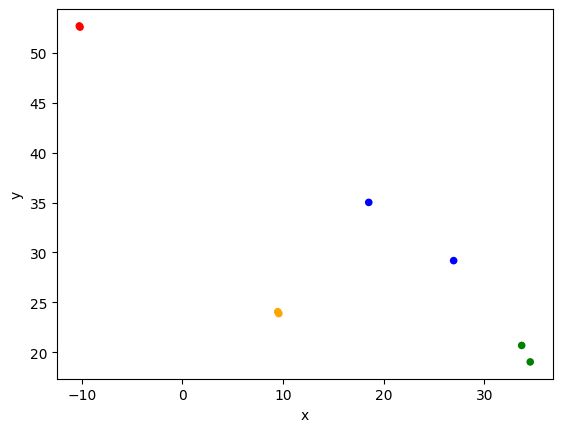

In [ ]:
reduced_and_plot_with_tsne(text_1_emb_matrix, text_2_emb_matrix,evaluate_df.index)

In [ ]:
def generate_embedding_using_pca(emb_matrix):

              # Create a PCA object and specify the number of components you want to keep
              n_components = 10  # Change this to the desired number of components
              pca = PCA(n_components=n_components)
              pca_reload = pk.load(open("/content/drive/MyDrive/pca.pkl",'rb'))
              # transform the data
              X_pca = pca_reload.transform(emb_matrix)  # Use X_scaled if you standardized your data
              return X_pca


In [ ]:
text_1_reduced_emb_matrix = generate_embedding_using_pca(text_1_emb_matrix)
text_2_reduced_emb_matrix = generate_embedding_using_pca(text_2_emb_matrix)

,x,y,color
0,-10.967161,39.353924,red
1,17.546286,14.690484,orange
2,18.838430,23.456619,blue
3,38.236294,23.722815,green
0,-11.367829,40.359352,red
1,39.643311,25.634407,orange
2,36.441322,13.815899,blue
3,39.461803,19.884624,green


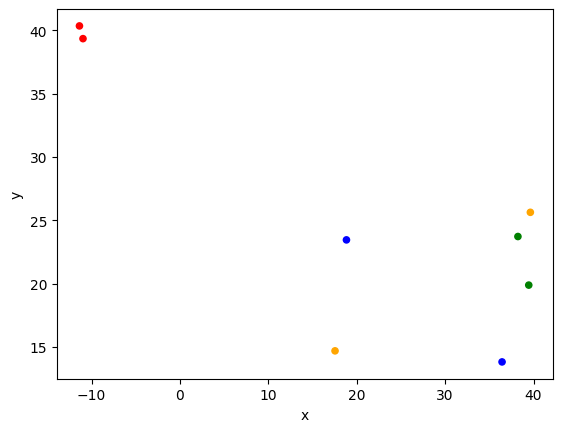

In [ ]:
reduced_and_plot_with_tsne(text_1_reduced_emb_matrix, text_2_reduced_emb_matrix,evaluate_df.index)